In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import skimage 
from skimage import io, filters

In [9]:
fname = "/Users/timrudge/RaspiScope/timelapse/timlap_3_%04d.jpg"
fname%(10)

'/Users/timrudge/RaspiScope/timelapse/timlap_3_0010.jpg'

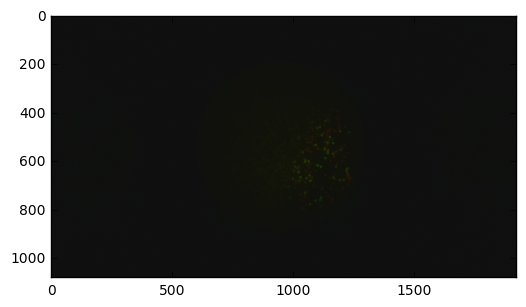

In [11]:
im = io.imread(fname%0)
plt.imshow(im)

In [14]:
im.shape

(1080, 1920, 3)

In [17]:
nt = 139
ims = np.zeros((1080,1920,nt))
for i in range(nt):
    im = io.imread(fname%i)
    ims[:,:,i] = im[:,:,1]

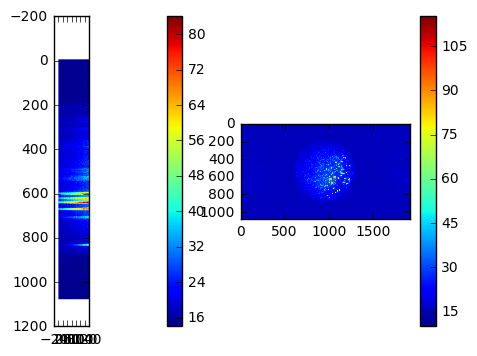

In [40]:
plt.subplot(1,2,1)
plt.imshow(ims[:,1000,:])
plt.colorbar()
plt.axis('scaled')
plt.subplot(1,2,2)
plt.imshow(ims[:,:,-1])
plt.colorbar()